In [1]:
# using einops!
import torch
import einops
t = torch.randn(2,4,34,34)
t.shape

torch.Size([2, 4, 34, 34])

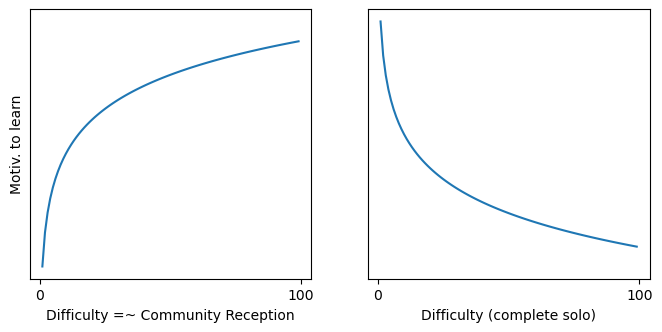

In [34]:
import matplotlib.pyplot as plt
import torch

fig,axes = plt.subplots(1,2,sharey=True)
fig.set_size_inches(8,3.5)
xs = torch.arange(1,100)
ys = torch.log(xs) / 5
ys2 = -torch.log(xs) / 5 + 1

axes[0].set_xlabel("Difficulty =~ Community Reception")
axes[0].set_ylabel("Motiv. to learn")
axes[0].set_yticks([])
axes[0].set_xticks([0,100])
axes[0].plot(xs,ys)


axes[1].set_xlabel("Difficulty (complete solo)")
axes[1].set_xticks([0,100])
axes[1].plot(xs,ys2)


In [2]:
# combining dimensions
print(einops.rearrange(t,'b c h w -> b c h w').shape)
print(einops.rearrange(t,'b c h w -> (b c) h w').shape)



torch.Size([2, 4, 34, 34])
torch.Size([8, 34, 34])


In [3]:
# permuting dimensions test
t = torch.randn(2,2,2)

print(t)
print("*********")
t2 = einops.rearrange(t,'b c d -> b d c')
print(t2)

print(t[0,0,1], t2[0,1,0])


tensor([[[-0.7444,  0.3859],
         [ 0.5750,  0.2586]],

        [[ 2.0826,  1.0728],
         [ 1.7080,  0.8891]]])
*********
tensor([[[-0.7444,  0.5750],
         [ 0.3859,  0.2586]],

        [[ 2.0826,  1.7080],
         [ 1.0728,  0.8891]]])
tensor(0.3859) tensor(0.3859)


In [4]:
# implementing the patch-embedding
w = 6
img = torch.arange(180).view(3,5,12)

# Goal: rearange: B,C,H,W -> B,H*W*C
# so dividing dims into nh and nw
img = einops.rearrange(img,'b c (w h) -> w b c h',
                       w = w)

img, img.shape

(tensor([[[[  0,   1],
           [ 12,  13],
           [ 24,  25],
           [ 36,  37],
           [ 48,  49]],
 
          [[ 60,  61],
           [ 72,  73],
           [ 84,  85],
           [ 96,  97],
           [108, 109]],
 
          [[120, 121],
           [132, 133],
           [144, 145],
           [156, 157],
           [168, 169]]],
 
 
         [[[  2,   3],
           [ 14,  15],
           [ 26,  27],
           [ 38,  39],
           [ 50,  51]],
 
          [[ 62,  63],
           [ 74,  75],
           [ 86,  87],
           [ 98,  99],
           [110, 111]],
 
          [[122, 123],
           [134, 135],
           [146, 147],
           [158, 159],
           [170, 171]]],
 
 
         [[[  4,   5],
           [ 16,  17],
           [ 28,  29],
           [ 40,  41],
           [ 52,  53]],
 
          [[ 64,  65],
           [ 76,  77],
           [ 88,  89],
           [100, 101],
           [112, 113]],
 
          [[124, 125],
           [136, 137],
    

In [5]:
# implementing the patch-embedding
patch_h = 1
patch_w = 1

ct = 2*3*2*2
img = torch.arange(ct).view(2,3,2,2)

# Goal: rearange: B,C,H,W -> B,H*W*C
# so dividing dims into nh and nw
img = einops.rearrange(img,'b c (nh ph) (nw pw) -> b (nh nw) (ph pw c)',
                       ph = patch_h,
                       pw = patch_w)

img, img.shape

(tensor([[[ 0,  4,  8],
          [ 1,  5,  9],
          [ 2,  6, 10],
          [ 3,  7, 11]],
 
         [[12, 16, 20],
          [13, 17, 21],
          [14, 18, 22],
          [15, 19, 23]]]),
 torch.Size([2, 4, 3]))

In [6]:
# testing out position embedding
import torch

def pos_emb(emb_dim,grid_dim,device):
    grid_size_h,gride_size_w = grid_dim
    
    grid_h = torch.arange(grid_size_h,dtype=torch.float32)
    grid_w = torch.arange(gride_size_w,dtype=torch.float32)
    
    
    # meshgrid: we show for the entire grid, the index of
    # the x & y choordinate for a given point.
    grid = torch.meshgrid(grid_h,grid_w,indexing='ij')
    
    # stack along 0th dimension. (grow size of 0th)
    grid = torch.stack(grid,dim=0)
    
    # obtaining our grid positions
    # for each tensor, the relative positions
    grid_h_pos = grid[0].reshape(-1)
    grid_w_pos = grid[1].reshape(-1)
    
    # now, using our formula
    # factor = 10k^(2i/d_model) for 2i + 1 cos, 2i sin
    factor = 10000 ** (torch.arange(
        start=0,
        end = emb_dim // 4, # for each cos and sin
        dtype = torch.float32,
        device = device
    )// (emb_dim//4)) # embedding dim for each cos/sin
    
    # now, we seperate the h embeddings into:
    grid_h_emb = grid_h_pos[:,None].repeat(1,emb_dim // 4) / factor
    grid_h_emb = torch.cat([torch.sin(grid_h_emb),torch.cos(grid_h_emb)],dim=-1)
    
    grid_w_emb = grid_w_pos[:,None].repeat(1,emb_dim // 4) / factor
    grid_w_emb = torch.cat([torch.sin(grid_w_emb),torch.cos(grid_w_emb)],dim=-1)
    
    final_emb = torch.cat([grid_h_emb,grid_w_emb],dim = -1)
    
    return final_emb




# so, dim is 4x4, 44 emb-dim

pos_emb(250,[25,25],'cpu')

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  1.0000,  1.0000,  1.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.5403,  0.5403,  0.5403],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.4161, -0.4161, -0.4161],
        ...,
        [-0.9056, -0.9056, -0.9056,  ..., -1.0000, -1.0000, -1.0000],
        [-0.9056, -0.9056, -0.9056,  ..., -0.5328, -0.5328, -0.5328],
        [-0.9056, -0.9056, -0.9056,  ...,  0.4242,  0.4242,  0.4242]])

In [7]:
import torch 
from einops import rearrange

t = torch.arange(120).view(3,5,8)
nh = 2
ph = 4

t2= rearrange(t,'b p (nh ph) -> ph b p nh',
          ph = ph)

t3 = rearrange(t,'b p (ph nh) -> ph b p nh',
          ph = ph)

'''

When permuting dimensions as such, we split
the dimension based on the indices, and
permute by switching location as usual

'''

t2, t3 # not equal, bc of order

(tensor([[[[  0,   4],
           [  8,  12],
           [ 16,  20],
           [ 24,  28],
           [ 32,  36]],
 
          [[ 40,  44],
           [ 48,  52],
           [ 56,  60],
           [ 64,  68],
           [ 72,  76]],
 
          [[ 80,  84],
           [ 88,  92],
           [ 96, 100],
           [104, 108],
           [112, 116]]],
 
 
         [[[  1,   5],
           [  9,  13],
           [ 17,  21],
           [ 25,  29],
           [ 33,  37]],
 
          [[ 41,  45],
           [ 49,  53],
           [ 57,  61],
           [ 65,  69],
           [ 73,  77]],
 
          [[ 81,  85],
           [ 89,  93],
           [ 97, 101],
           [105, 109],
           [113, 117]]],
 
 
         [[[  2,   6],
           [ 10,  14],
           [ 18,  22],
           [ 26,  30],
           [ 34,  38]],
 
          [[ 42,  46],
           [ 50,  54],
           [ 58,  62],
           [ 66,  70],
           [ 74,  78]],
 
          [[ 82,  86],
           [ 90,  94],
    

In [8]:
# creating custom layernorm
import torch
nin,nout = 30, 300
n = torch.randn([nin,nout])

n = (n - n.mean(dim=-1,keepdim=True)) / (n.std(dim=-1,keepdim=True) + 0)

n

tensor([[ 0.6145, -1.1614,  2.4129,  ...,  0.7041, -0.2702, -0.5480],
        [ 1.4022,  1.1210, -0.0133,  ..., -0.7224,  1.1330, -1.4041],
        [-1.0911,  2.2567, -0.0419,  ...,  1.8025,  0.6399,  0.0396],
        ...,
        [ 1.3575,  0.2255, -0.5029,  ...,  0.0229,  1.0152, -0.6778],
        [ 0.7340,  1.0899, -2.4978,  ..., -0.0961,  0.3418, -0.6880],
        [-1.2445, -0.0147,  2.0132,  ..., -0.3695, -1.0155,  0.6094]])

In [9]:
import torch

# Emb
t = torch.arange(6).view(2,3)
# P, Emb
ones = torch.ones([2, 200,3])
t = t.unsqueeze(1)

# [2,1,3] * [2,200,3]
t + ones

tensor([[[1., 2., 3.],
         [1., 2., 3.],
         [1., 2., 3.],
         ...,
         [1., 2., 3.],
         [1., 2., 3.],
         [1., 2., 3.]],

        [[4., 5., 6.],
         [4., 5., 6.],
         [4., 5., 6.],
         ...,
         [4., 5., 6.],
         [4., 5., 6.],
         [4., 5., 6.]]])